<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-01-30 21:54:51--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2022-01-30 21:54:51 (11.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



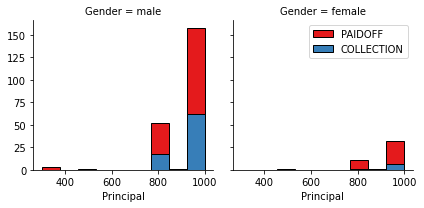

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

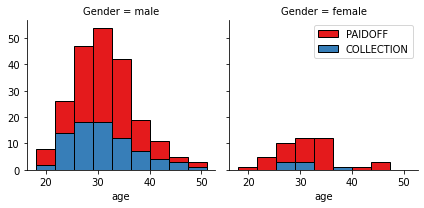

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


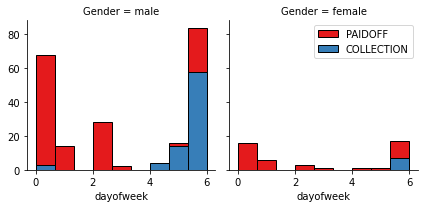

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Training with 4
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
print(neigh)

#Predict
yhat = neigh.predict(X_test)
print(yhat[0:5])

print("Train set Accuracy (K=4): ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy (K=4): ", metrics.accuracy_score(y_test, yhat))

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
KNeighborsClassifier(n_neighbors=4)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
Train set Accuracy (K=4):  0.822463768115942
Test set Accuracy (K=4):  0.6


In [27]:
#K=6
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy for K=6: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy for K=6: ", metrics.accuracy_score(y_test, yhat6))


Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

Train set Accuracy for K=6:  0.7681159420289855
Test set Accuracy for K=6:  0.6857142857142857


array([0.61428571, 0.54285714, 0.68571429, 0.6       , 0.72857143,
       0.68571429, 0.68571429, 0.68571429, 0.74285714])

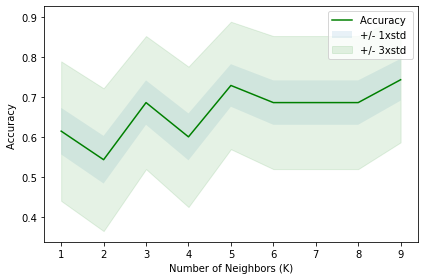

The best accuracy was with 0.7428571428571429 with k= 9


In [28]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


# Decision Tree


In [30]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from  io import StringIO
#import pydotplus
import matplotlib.image as mpimg
#Decision Tree
#Setting up Decision Tree
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))

print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))


drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree # it shows the default parameters

drugTree.fit(X_trainset,y_trainset)

predTree = drugTree.predict(X_testset)

print (predTree [0:5])
print (y_testset [0:5])

Shape of X training set (242, 8) &  Size of Y training set (242,)
Shape of X training set (104, 8) &  Size of Y training set (104,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |             py_3          23 KB  anaconda
    ------------------------------------------------------------
                                           Total:          23 KB

The following NEW packages will be INSTALLED:

  pydotplus          anaconda/noarch::pydotplus-2.0.2-py_3



pydotplus-2.0.2      | 23 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
FeatureNames:  Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age'],
      dtype='object')
DecisionTrees's Accuracy:  0.6538461538461539


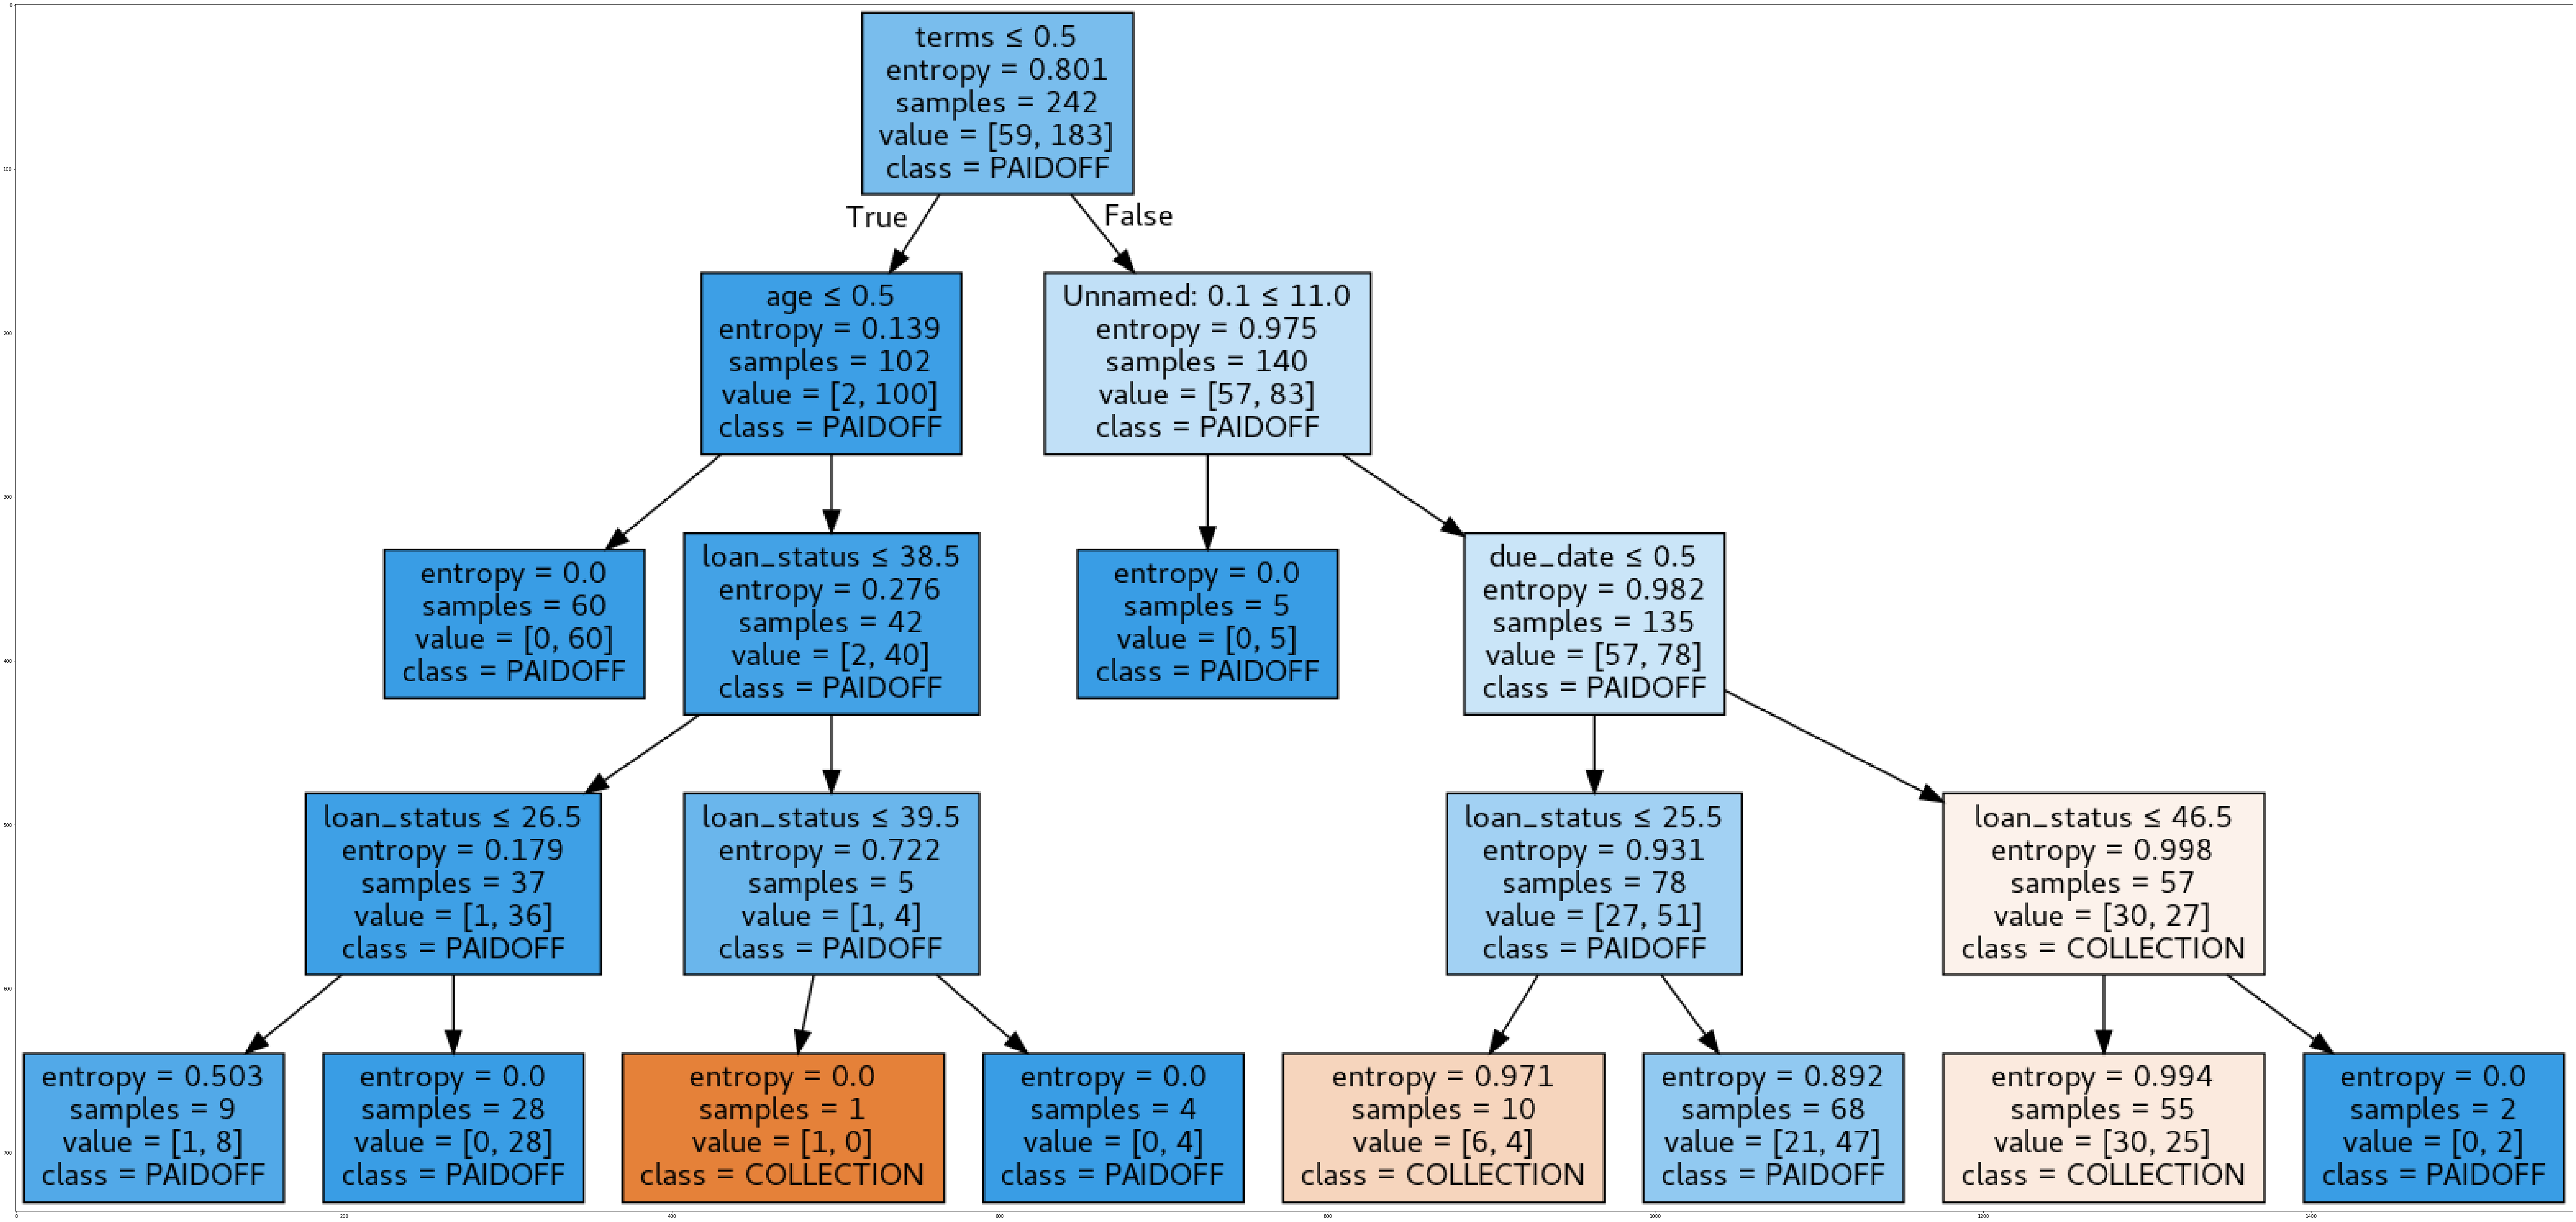

In [39]:
!conda install -c anaconda pydotplus
import pydotplus
#!conda install -c anaconda graphviz
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df.columns[0:8]
print("FeatureNames: " , featureNames);
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree)) 


# Support Vector Machine


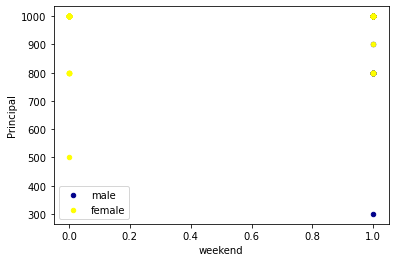

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object
Train set: (207, 8) (207,)
Test set: (139, 8) (139,)
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        37
     PAIDOFF       0.73      1.00      0.85       102

    accuracy                           0.73       139
   macro avg       0.37      0.50      0.42       139
weighted avg       0.54      0.73      0.62       139

Confusion matrix, without normalization
[[102   0]
 [ 37   0]]
SVM RBF Avg F1-score:  0.6212
SVM RBF Jaccard score: 0.7338


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


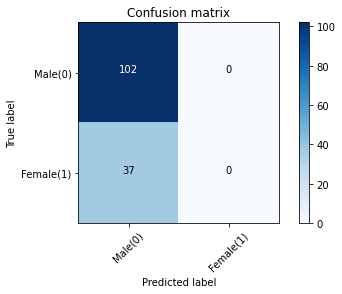

In [43]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
ax = df[df['Gender'] == 0][0:50].plot(kind='scatter', x='weekend', y='Principal', color='DarkBlue', label='male');
df[df['Gender'] == 1][0:50].plot(kind='scatter', x='weekend', y='Principal', color='Yellow', label='female', ax=ax);
plt.show()

print(df.dtypes)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape) 



clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
yhat [0:5]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Male(0)','Female(1)'],normalize= False,  title='Confusion matrix')


f1_score(y_test, yhat, average='weighted')

jaccard_score(y_test, yhat,pos_label='PAIDOFF')

print("SVM RBF Avg F1-score:  %.4f" % f1_score(y_test, yhat, average='weighted'))
print("SVM RBF Jaccard score: %.4f" % jaccard_score(y_test, yhat,pos_label='PAIDOFF'))



In [44]:
#SVM Model Testing with linear
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("SVM Linear Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("SVM Linear Jaccard score: %.4f" % jaccard_score(y_test, yhat2,pos_label='PAIDOFF'))

#SVM Model Testing with poly
clf3 = svm.SVC(kernel='poly')
clf3.fit(X_train, y_train) 
yhat3 = clf3.predict(X_test)
print("SVM Polynomial Avg F1-score: %.4f" % f1_score(y_test, yhat3, average='weighted'))
print("SVM Polynomial Jaccard score: %.4f" % jaccard_score(y_test, yhat3,pos_label='PAIDOFF'))



SVM Linear Avg F1-score: 0.6212
SVM Linear Jaccard score: 0.7338
SVM Polynomial Avg F1-score: 0.6212
SVM Polynomial Jaccard score: 0.7338


In [45]:
#SVM Model Testing with sigmoid
clf4 = svm.SVC(kernel='sigmoid')
clf4.fit(X_train, y_train) 
yhat4 = clf4.predict(X_test)
print("SVM Sigmoid Avg F1-score: %.4f" % f1_score(y_test, yhat4, average='weighted'))
print("SVM Sigmoid Jaccard score: %.4f" % jaccard_score(y_test, yhat4,pos_label='PAIDOFF'))


SVM Sigmoid Avg F1-score: 0.6212
SVM Sigmoid Jaccard score: 0.7338


# Logistic Regression


In [47]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

yhat = LR.predict(X_test)
yhat

yhat_prob = LR.predict_proba(X_test)
print("Regression Probabbility : " , yhat_prob)
print("Jaccard Score : " , jaccard_score(y_test, yhat,pos_label='PAIDOFF'))


Regression Probabbility :  [[0.29 0.71]
 [0.23 0.77]
 [0.17 0.83]
 [0.3  0.7 ]
 [0.23 0.77]
 [0.19 0.81]
 [0.25 0.75]
 [0.22 0.78]
 [0.3  0.7 ]
 [0.26 0.74]
 [0.28 0.72]
 [0.28 0.72]
 [0.3  0.7 ]
 [0.28 0.72]
 [0.12 0.88]
 [0.15 0.85]
 [0.35 0.65]
 [0.17 0.83]
 [0.3  0.7 ]
 [0.21 0.79]
 [0.26 0.74]
 [0.28 0.72]
 [0.32 0.68]
 [0.33 0.67]
 [0.19 0.81]
 [0.3  0.7 ]
 [0.31 0.69]
 [0.14 0.86]
 [0.31 0.69]
 [0.13 0.87]
 [0.19 0.81]
 [0.31 0.69]
 [0.25 0.75]
 [0.25 0.75]
 [0.2  0.8 ]
 [0.17 0.83]
 [0.3  0.7 ]
 [0.13 0.87]
 [0.29 0.71]
 [0.2  0.8 ]
 [0.32 0.68]
 [0.22 0.78]
 [0.15 0.85]
 [0.3  0.7 ]
 [0.17 0.83]
 [0.31 0.69]
 [0.2  0.8 ]
 [0.28 0.72]
 [0.17 0.83]
 [0.16 0.84]
 [0.23 0.77]
 [0.17 0.83]
 [0.23 0.77]
 [0.26 0.74]
 [0.26 0.74]
 [0.1  0.9 ]
 [0.2  0.8 ]
 [0.23 0.77]
 [0.19 0.81]
 [0.26 0.74]
 [0.11 0.89]
 [0.26 0.74]
 [0.17 0.83]
 [0.36 0.64]
 [0.22 0.78]
 [0.28 0.72]
 [0.26 0.74]
 [0.18 0.82]
 [0.15 0.85]
 [0.22 0.78]
 [0.15 0.85]
 [0.32 0.68]
 [0.24 0.76]
 [0.22 0.78]
 [0.27 0.73

[[102   0]
 [ 37   0]]
Confusion matrix, without normalization
[[102   0]
 [ 37   0]]
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        37
     PAIDOFF       0.73      1.00      0.85       102

    accuracy                           0.73       139
   macro avg       0.37      0.50      0.42       139
weighted avg       0.54      0.73      0.62       139

LogLoss: : 0.58


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


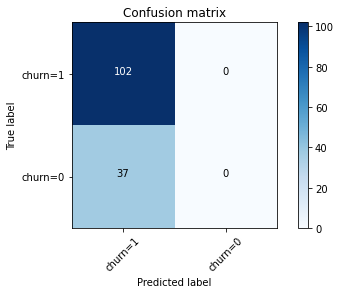

In [48]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION']))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')


print (classification_report(y_test, yhat))

log_loss(y_test, yhat_prob)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob))

In [49]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss:  %.2f" % log_loss(y_test, yhat_prob2))


LogLoss: : 0.59


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


# Model Evaluation using Test set


In [34]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [35]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-01-30 23:54:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-01-30 23:54:07 (80.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [36]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [50]:
#Evaluating  KNN Model Accuracy with Jaccard Score and F1 Score. 
k=9
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
print(Feature.head())

X = Feature
X[0:5]

y = df['loan_status'].values
y[0:5]

#Normalize data
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

neigh9 = KNeighborsClassifier(n_neighbors = k).fit(X,y)
yhat9 = neigh9.predict(X)
print("Jaccard Score : KNN 9 " , jaccard_score(y, yhat9,pos_label='PAIDOFF'))
print("Avg F1-score: KNN  %.4f" % f1_score(y, yhat9, average='weighted'))

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  
Jaccard Score : KNN 9  0.7813504823151125
Avg F1-score: KNN  0.7853


In [53]:
# Model Evaluation for Decision Tree Jaccard Score and F1 Score
drugTree.fit(X,y)

predTree = drugTree.predict(X)
print("Decision Tree Jaccard Score : " , jaccard_score(y, predTree, pos_label='PAIDOFF'))
print("Decision Tree Avg F1-score:  %.4f" % f1_score(y, predTree, average='weighted'))

Decision Tree Jaccard Score :  0.7470588235294118
Decision Tree Avg F1-score:  0.6731


In [57]:
#Model evaluation for SVM - RBF, linear, poly, sigmoid.

clf = svm.SVC(kernel='rbf')
clf.fit(X, y)
yhat = clf.predict(X)
yhat [0:5]
print("SVM RBF Avg F1-score: %.4f" % f1_score(y, yhat, average='weighted'))
print("SVM RBF Jaccard score: %.4f" % jaccard_score(y, yhat,pos_label='PAIDOFF'))
print(" ")
clf2 = svm.SVC(kernel='linear')
clf2.fit(X, y) 
yhat2 = clf2.predict(X)
yhat2 [0:5]
print("SVM Linear Avg F1-score: %.4f" % f1_score(y, yhat2, average='weighted'))
print("SVM Linear Jaccard score: %.4f" % jaccard_score(y, yhat2,pos_label='PAIDOFF'))
print(" ")

clf3 = svm.SVC(kernel='poly')
clf3.fit(X, y) 
yhat3 = clf3.predict(X)
yhat3 [0:5]
print("SVM Polynomial Avg F1-score: %.4f" % f1_score(y, yhat3, average='weighted'))
print("SVM Polynomial Jaccard score: %.4f" % jaccard_score(y, yhat3,pos_label='PAIDOFF'))
print(" ")

clf4 = svm.SVC(kernel='sigmoid')
clf4.fit(X, y) 
yhat4 = clf4.predict(X)
yhat4 [0:5]
print("SVM Sigmoid Avg F1-score: %.4f" % f1_score(y, yhat4, average='weighted'))
print("SVM Sigmoid Jaccard score: %.4f" % jaccard_score(y, yhat4,pos_label='PAIDOFF'))
print(" ")

SVM RBF Avg F1-score: 0.6648
SVM RBF Jaccard score: 0.7580
 
SVM Linear Avg F1-score: 0.6448
SVM Linear Jaccard score: 0.7514
 
SVM Polynomial Avg F1-score: 0.7180
SVM Polynomial Jaccard score: 0.7718
 
SVM Sigmoid Avg F1-score: 0.6320
SVM Sigmoid Jaccard score: 0.7159
 


In [75]:

# Model Evaluation for  Logistic Regression 
LR1 = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
yhat_prob1 = LR1.predict_proba(X)
print ("Logistic Regression - Lib Linear LogLoss: : %.2f" % log_loss(y, yhat_prob1))



pred1=LR1.predict(X)
print (classification_report(y, pred1))
print("Logistic Regression - Lib Linear Jaccard score: %.4f" % jaccard_score(y, pred1, pos_label='PAIDOFF'))
print("Logistic Regression - Lib Linear F1-score: %.4f" % f1_score(y, pred1, pos_label='PAIDOFF'))





LR2 = LogisticRegression(C=0.01, solver='sag').fit(X,y)
yhat_prob2 = LR2.predict_proba(X)
print ("Logistic Regression - Sag LogLoss: : %.2f" % log_loss(y, yhat_prob2))



pred=LR2.predict(X)
print (classification_report(y, pred))
print("Logistic Regression - Sag Jaccard score: %.4f" % jaccard_score(y, pred, pos_label='PAIDOFF'))
print("Logistic Regression - Sag F1-score: %.4f" % f1_score(y, pred, pos_label='PAIDOFF'))

Logistic Regression - Lib Linear LogLoss: : 0.54
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        86
     PAIDOFF       0.75      1.00      0.86       260

    accuracy                           0.75       346
   macro avg       0.38      0.50      0.43       346
weighted avg       0.56      0.75      0.64       346

Logistic Regression - Lib Linear Jaccard score: 0.7486
Logistic Regression - Lib Linear F1-score: 0.8562
Logistic Regression - Sag LogLoss: : 0.49
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        86
     PAIDOFF       0.75      1.00      0.86       260

    accuracy                           0.75       346
   macro avg       0.38      0.50      0.43       346
weighted avg       0.56      0.75      0.64       346

Logistic Regression - Sag Jaccard score: 0.7514
Logistic Regression - Sag F1-score: 0.8581


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
